In [2]:
import numpy as np
import pandas as pd
import math
import zipfile         # a core library for working with zip files
import requests        # third-party library for making HTTP requests
from functools import reduce
import os
import matplotlib.pyplot as plt

#pd.set_option('display.max_columns', 100)
pd.options.display.float_format = '{:.2f}'.format
pd.set_option("display.max_columns", 330)

#### Load in HUD AMI data 

In [212]:
# read in HUD AMI data downloaded for each year from here https://www.huduser.gov/portal/datasets/il.html#2010
path = os.getcwd()
df = pd.DataFrame()
for filename in os.listdir(path):
    if filename.startswith("HUD-IL"):
        df_new = pd.read_csv(os.path.join(path, filename))
        df_new["year"] = filename[-8:-4]
        median_col = [x for x in df_new.columns if "median" in x]

        df_new = df_new.rename(columns={median_col[0]:"median"})

        columns = ["State_Alpha","County_Name","Metro_Area_Name","year","median"]
        df_new = df_new[columns]
        df = pd.concat([df1,df_new],ignore_index=True)
df = df[df.State_Alpha =="CA"]#filter for california
#df.to_csv("california_hud_AMI_levels_2010-2019.csv")

In [22]:
df.head()

,State_Alpha,County_Name,Metro_Area_Name,year,median
186,CA,Alameda County,"Oakland-Fremont, CA HUD Metro FMR Area",2018,104400
187,CA,Alpine County,"Alpine County, CA",2018,77800
188,CA,Amador County,"Amador County, CA",2018,73600
189,CA,Butte County,"Chico, CA MSA",2018,60500
190,CA,Calaveras County,"Calaveras County, CA",2018,72300


#### Load in PUMS household Data

In [ ]:
#got data below from downloading these zips, do with code if time 
for i in range_list:
    print("https://www2.census.gov/programs-surveys/acs/data/pums/"+i+"/1-Year/csv_hca.zip")

In [ ]:
hca = pd.DataFrame()
path_csv = path + "/csv_hca"

columns = ["PUMA","county1"]
crosswalk_df=pd.read_csv("PUMA_County_Crosswalk.csv", delimiter=",",usecols=columns)#https://mcdc.missouri.edu/applications/geocorr2018.html


for filename in os.listdir(path_csv):
    df_new1 = pd.read_csv(os.path.join(path_csv, filename))
    df_new1= read_in_PUMS(df_new1,col_names)
    df_new1["year"] = filename[-8:-4] 
    hca = pd.concat([hca,df_new1],ignore_index=True)

hca2 = bring_in_crosswalk(hca,crosswalk_df) #bring in crosswalk data 
cols_to_keep_hca = ["County","year","type","weight","ST",
                    "number_bedrooms","record_type","PUMA","REGION",
                    "ppl_in_hh","first_mortgage","monthly_rent",
                    "hh_income","num_own_chldrn","num_relate_chldrn"] #subset cols 
pums_ca = hca2[cols_to_keep_hca]
#hca3.to_csv("2010-2019_ca_household_survey.csv")
#pums_ca = pd.read_csv("2010-2019_ca_household_survey.csv")

In [23]:
pums_sub_cols = ['County', 'year',"hh_income","ppl_in_hh",'PUMA']# i took more cols just in case from big dataset, but this is all we need for thi calc 
pums_ca = pums_ca[pums_sub_cols]

In [33]:
len(pums_ca)#1396700 before dropna 

1396700

In [48]:
pums_ca = pums_ca.dropna() # we lose ~300k records for having null values 

In [102]:
# we lose 7896 by getting rid of entries with bad types, acceptable error in a dataset this big 
pums_ca = pums_ca[pd.to_numeric(pums_ca['hh_income'], errors='coerce').notnull()]
pums_ca.hh_income = pums_ca.hh_income.astype(float) #convert to float so we can do calculations 

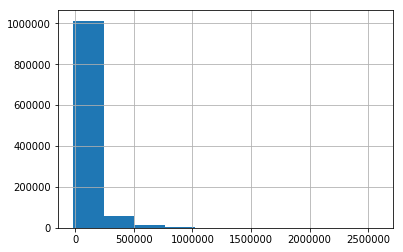

In [106]:
import matplotlib.pyplot as plt
#check for outliers in hh income 
pums_ca.hh_income.hist()

In [107]:
#in this dataset negative income doenst really make sense, so I'll drop those rows
#strange to see renter with 2.5 million income, but certainly not impossible in sf 
pums_ca.hh_income.describe()

count   1087782.00
mean      98613.07
std      107896.17
min      -15700.00
25%       33400.00
50%       69100.00
75%      124500.00
max     2580000.00
Name: hh_income, dtype: float64

In [109]:
pums_ca = pums_ca[pums_ca['hh_income'] >=0] #drop negative hh income  

Need to adjust for family size 

"Calculation of income limits for other family sizes is straight-forward. The 1-person family income limit is 70% of the 4-person income limit. The 2-person family income limit is 80% of the 4-person income limit, the 3-person family income limit is 90% of the 4-person income limit, the 5-person income limit is 108% of the 4-person income limit, the 6-person family income limit is 116% of the 4-person income limit, the 7-person family income limit is 124% of the 4-person income limit, and the 8-person family income limit is 132% of the 4-person income limit. For family sizes larger than 8 persons, the income limit can be calculated by adding an additional eight (8) percent per person to the next lower limit. For example a 9-person family income limit is 140% (132% + 8%), and so on. The resulting low-income limit calculation for other family sizes are then rounded up to the nearest $50 to produce the Final VLIL."

https://www.huduser.gov/portal/datasets/il/il2020/2020IlCalc.odn


In [129]:
#need to have household adjustments for up to size 20 
pums_ca.ppl_in_hh.value_counts()

2     349814
1     260238
3     177901
4     156784
5      79694
6      35001
7      14443
8       6794
9       3137
10      1602
11       842
12       524
13       188
14       113
15        55
16        32
20        26
17        19
18        12
19         5
Name: ppl_in_hh, dtype: int64

In [132]:
family_size_dict = {1:.7,
                   2:.8,
                   3:.9,
                   4:1,
                    5:1.08,
                    6:1.16,
                    7:1.24,
                    8:1.32,
                   9:1.40,
                   10:1.48,
                   11:1.56,
                   12:1.64,
                   13:1.72,
                   14:1.80,
                   15:1.88,
                   16:1.96,
                   17:2.04,
                   18:2.12,
                   19:2.20,
                   20:2.28}

In [137]:
len(pums_ca.County.unique())

41

In [139]:
pums_ca.head()

,County,year,hh_income,ppl_in_hh,PUMA
0,Santa Clara,2012,105000.00,2,8508
2,San Mateo,2012,39600.00,1,8105
3,Contra Costa,2012,269000.00,2,1305
4,Kern,2012,65200.00,2,2901
5,Santa Clara,2012,80000.00,1,8511


In [145]:
pums_ca.County = pums_ca.County +" County" #make naming conventions align so can merge
pums_ca["key"] = pums_ca["County"] + pums_ca["year"].astype(str) #make keys to match on 
df["key"] = df["County_Name"] + df["year"].astype(str)

In [150]:
#need to create range of values for each county 
df["80%_AMI"] = df["median"] * 0.8
df["120%_AMI"] = df["median"] * 1.2

In [218]:
df_merged = pums_ca.merge(df,on="key",how="left")

In [220]:
df_merged = df_merged.drop(columns={"year_x"})
df_merged = df_merged.rename(columns={"year_y":"year"})

In [222]:
df_merged["80%_AMI"] = df_merged["median"] * 0.8
df_merged["120%_AMI"] = df_merged["median"] * 1.2

,County,hh_income,ppl_in_hh,PUMA,key,State_Alpha,County_Name,Metro_Area_Name,year,median,80%_AMI,120%_AMI
0,Santa Clara County,105000.00,2,8508,Santa Clara County2012,CA,Santa Clara County,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",2012,105000,84000.00,126000.00
1,San Mateo County,39600.00,1,8105,San Mateo County2012,CA,San Mateo County,"San Francisco, CA HUD Metro FMR Area",2012,103000,82400.00,123600.00
2,Contra Costa County,269000.00,2,1305,Contra Costa County2012,CA,Contra Costa County,"Oakland-Fremont, CA HUD Metro FMR Area",2012,93500,74800.00,112200.00
3,Kern County,65200.00,2,2901,Kern County2012,CA,Kern County,"Bakersfield-Delano, CA MSA",2012,54100,43280.00,64920.00
4,Santa Clara County,80000.00,1,8511,Santa Clara County2012,CA,Santa Clara County,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",2012,105000,84000.00,126000.00


In [227]:
#make new column of the AMI multiplier based on each households family size 
df_merged["family_size_multiplier"] = df_merged["ppl_in_hh"].map(family_size_dict)

In [229]:
#adjust ami bands for each household based on household size 
df_merged["80%_AMI_adjusted"] = df_merged["80%_AMI"] * df_merged["family_size_multiplier"]
df_merged["120%_AMI_adjusted"] = df_merged["120%_AMI"] * df_merged["family_size_multiplier"]

In [230]:
#want to subset data to only keep households inbtween 80% and 120% for her household 
df_merged.head()

,County,hh_income,ppl_in_hh,PUMA,key,State_Alpha,County_Name,Metro_Area_Name,year,median,80%_AMI,120%_AMI,family_size_multiplier,80%_AMI_adjusted,120%_AMI_adjusted
0,Santa Clara County,105000.00,2,8508,Santa Clara County2012,CA,Santa Clara County,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",2012,105000,84000.00,126000.00,0.80,67200.00,100800.00
1,San Mateo County,39600.00,1,8105,San Mateo County2012,CA,San Mateo County,"San Francisco, CA HUD Metro FMR Area",2012,103000,82400.00,123600.00,0.70,57680.00,86520.00
2,Contra Costa County,269000.00,2,1305,Contra Costa County2012,CA,Contra Costa County,"Oakland-Fremont, CA HUD Metro FMR Area",2012,93500,74800.00,112200.00,0.80,59840.00,89760.00
3,Kern County,65200.00,2,2901,Kern County2012,CA,Kern County,"Bakersfield-Delano, CA MSA",2012,54100,43280.00,64920.00,0.80,34624.00,51936.00
4,Santa Clara County,80000.00,1,8511,Santa Clara County2012,CA,Santa Clara County,"San Jose-Sunnyvale-Santa Clara, CA HUD Metro F...",2012,105000,84000.00,126000.00,0.70,58800.00,88200.00


In [233]:
len(df_merged)

1222747

In [232]:
middle_income = df_merged[(df_merged["hh_income"] >= df_merged["80%_AMI"])&(df_merged["hh_income"] <= df_merged["120%_AMI"])]

In [235]:
len(middle_income)/len(df_merged) # 17.6 percent of households in our dataset fall into this middle income category

0.1762392383706523

In [236]:
#need to address discrepency in number of counties - seems to be just smaller counties missing 
len(df.County_Name.unique()) - len(pums_ca.County.unique())

17

In [134]:
df.County_Name.unique()

array(['Alameda County', 'Alpine County', 'Amador County', 'Butte County',
       'Calaveras County', 'Colusa County', 'Contra Costa County',
       'Del Norte County', 'El Dorado County', 'Fresno County',
       'Glenn County', 'Humboldt County', 'Imperial County',
       'Inyo County', 'Kern County', 'Kings County', 'Lake County',
       'Lassen County', 'Los Angeles County', 'Madera County',
       'Marin County', 'Mariposa County', 'Mendocino County',
       'Merced County', 'Modoc County', 'Mono County', 'Monterey County',
       'Napa County', 'Nevada County', 'Orange County', 'Placer County',
       'Plumas County', 'Riverside County', 'Sacramento County',
       'San Benito County', 'San Bernardino County', 'San Diego County',
       'San Francisco County', 'San Joaquin County',
       'San Luis Obispo County', 'San Mateo County',
       'Santa Barbara County', 'Santa Clara County', 'Santa Cruz County',
       'Shasta County', 'Sierra County', 'Siskiyou County',
       'Solano 

Things to think about:

MAKE HOUSEHOLD INCOME AN INT, check for outliers on it, and anything else analysis will be done on. 

Do I need to take into account number of people in households? Can I do this in a formulaic way?

Need to take median and make 80-120% bands and then filter on that after match. 

then groupby year, will already be filtered for people within income bands. 